(전처리 안 한)lgbm vs (전처리 파생변수 등등)lgbm 이렇게 비교해서 모델링 과정이랑 몇 프로 올랐는지 결과쓰고 다양한 모델 시도 필요 같은 한계점 시사로 마무리

# 1. 라이브러리 및 데이터 로드
**변수 설명**  
1. id - 고유 id
2. CustomerId - 고객 id
3. Surname - 고객 이름
4. CreditScore - 고객의 신용 점수  
5. Geography -	고객의 거주 국가
6. Gender -	성별 (Male, Female)  
7. Age - 나이  
8. Tenure	- 은행과 거래한 기간(년)
9. Balance - 계좌 잔액
0. NumOfProducts - 보유 금융 상품 수
1. HasCrCard - 신용카드 보유 여부 (0=없음, 1=있음)
2. IsActiveMember	- 활성 고객 여부 (0=비활성, 1=활성)
3. EstimatedSalary - 추정 연봉
4. Exited	종속 변수 - 고객 이탈 여부 (1=이탈, 0=유지)

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    recall_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import lightgbm as lgb

In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/choi_son_wang_jo_LetsGo

/content/drive/MyDrive/Colab Notebooks/choi_son_wang_jo_LetsGo


In [5]:
train = pd.read_csv("./Data/train.csv")
test = pd.read_csv('./Data/test.csv')
sub_sample = pd.read_csv('./Data/sample_submission.csv')

print(train.shape)
print(train.info())

(165034, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB
None


In [ ]:
# 타켓 불균형 확인
train['Exited'].value_counts(normalize=True)

,proportion
Exited,
0,0.788401
1,0.211599


# 2. EDA

```
# boxplot을 이용해 대략적으로 이상치 파악
cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i])   # 각 subplot에 boxplot
    axes[i].set_title(col)

# 남는 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
```

```
# kdeplot 확인
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.kdeplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)

# 남는 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
```

# 3. 전처리

In [6]:
def preprocessing(df):
    """
    1. 불필요한 변수 제거
    2. 범주형 변수 원-핫 인코딩
    등등 여기 추가
    """
    # 불필요한 변수 제거
    df = df.drop(['id', 'CustomerId', 'Surname'], axis=1)

    # 원-핫 인코딩
    cat_features = ["Gender", "Geography"] # 2차 때 NumOfProducts 추가
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    encoded = encoder.fit_transform(df[cat_features])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_features), index=df.index)

    df = pd.concat([df.drop(cat_features, axis=1), encoded_df], axis=1)

    return df

train = preprocessing(train)
test = preprocessing(test)

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        165034 non-null  int64  
 1   Age                165034 non-null  float64
 2   Tenure             165034 non-null  int64  
 3   Balance            165034 non-null  float64
 4   NumOfProducts      165034 non-null  int64  
 5   HasCrCard          165034 non-null  float64
 6   IsActiveMember     165034 non-null  float64
 7   EstimatedSalary    165034 non-null  float64
 8   Exited             165034 non-null  int64  
 9   Gender_Male        165034 non-null  float64
 10  Geography_Germany  165034 non-null  float64
 11  Geography_Spain    165034 non-null  float64
dtypes: float64(8), int64(4)
memory usage: 15.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 11 columns):
 #   Column             Non-Null Cou

In [7]:
print(train.isna().sum(), "\n")
print(train.duplicated().sum())

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Gender_Male          0
Geography_Germany    0
Geography_Spain      0
dtype: int64 

123


결측치, 중복 없음

# 4. 모델 정의 및 학습

In [8]:
X = train.drop(columns=["Exited"])
y = train["Exited"]

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}\n")

Train set: (132027, 11), (132027,)
Validation set: (33007, 11), (33007,)



In [11]:
# 모델 학습
print("--- LGBM 모델 학습 시작 ---")

lgbm_model = lgb.LGBMClassifier(
    random_state=42,
    objective='binary',
    n_estimators=10,
    num_leaves=5,
    metric=['auc', 'recall'], # auc, recall 둘 다 씀
    is_unbalance=True         # 이거 안 쓰면 recall 0.5대로 추락함 ㄷㄷ
)

lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['auc', 'recall'],
    callbacks=[lgb.early_stopping(100)],
)

print("--- 모델 학습 완료 ---")


# --- 5. 모델 성능 평가 ---
print("\n--- 모델 성능 평가 (validation Set) ---")

# 예측 (0 또는 1)
y_pred = lgbm_model.predict(X_val)

# 예측 확률 (0일 확률, 1일 확률)
y_pred_proba = lgbm_model.predict_proba(X_val)[:, 1]

# 평가
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred_proba):.4f}")

recall = recall_score(y_val, y_pred)
print(f"Recall Score: {recall:.4f}")

print("\n[ Confusion Matrix ]")
print(confusion_matrix(y_val, y_pred))

print("\n[ Classification Report ]")
print(classification_report(y_val, y_pred))

--- LGBM 모델 학습 시작 ---
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.861591
--- 모델 학습 완료 ---

--- 모델 성능 평가 (validation Set) ---
ROC AUC Score: 0.8616
Recall Score: 0.6345

[ Confusion Matrix ]
[[23117  2906]
 [ 2553  4431]]

[ Classification Report ]
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     26023
           1       0.60      0.63      0.62      6984

    a

- n_estimators=50,
- num_leaves=10,
```
--- 모델 성능 평가 (validation Set) ---
ROC AUC Score: 0.8880
Recall Score: 0.7961
```
<br>

- n_estimators=10,
- num_leaves=5,
```
--- 모델 성능 평가 (validation Set) ---
ROC AUC Score: 0.8616
Recall Score: 0.6345
```

# SHAP

--- SHAP 값 계산 시작 (Baseline Model) ---
--- SHAP 값 계산 완료 ---

--- SHAP Summary Plot (Bar) ---


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


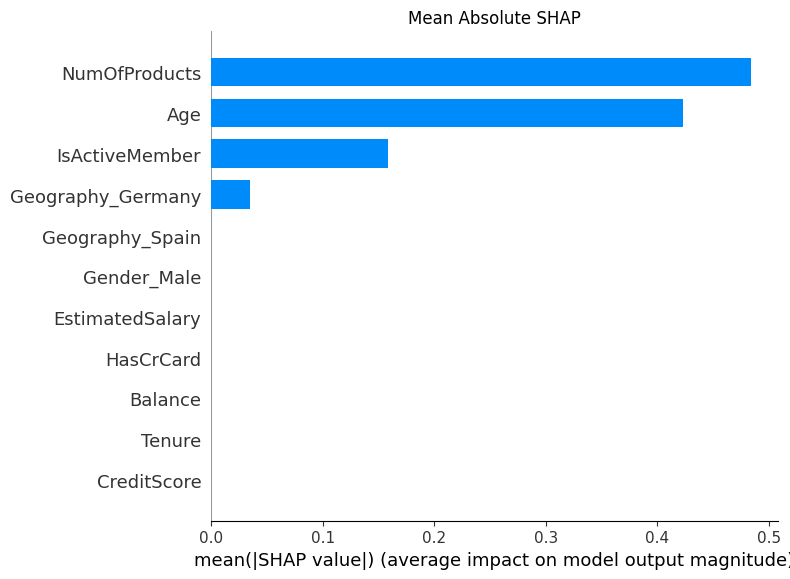


--- SHAP Summary Plot (Beeswarm) ---


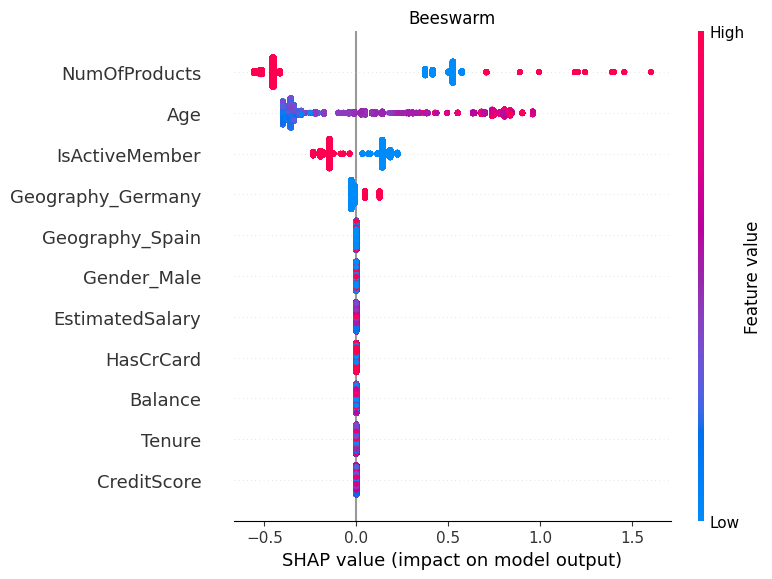


--- SHAP Dependence Plot for 'Age' ---


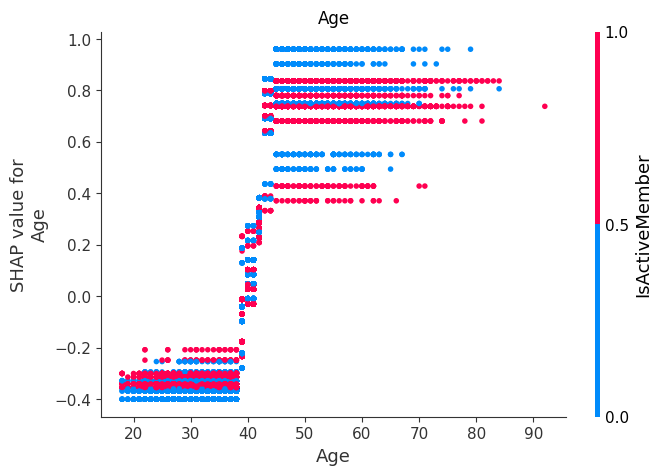

In [12]:
import shap
import matplotlib.pyplot as plt

# --- 1. SHAP Explainer 로드 및 값 계산 ---
# (lgbm_model, X_val는 이전 코드에서 생성된 것을 사용)

print("--- SHAP 값 계산 시작 (Baseline Model) ---")
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_val) # <- 여기서 2D 매트릭스가 반환됨
print("--- SHAP 값 계산 완료 ---")

# --- 2. SHAP 요약 플롯 (Global Interpretation) ---

# [A] 전역 변수 중요도 (Bar Plot)
print("\n--- SHAP Summary Plot (Bar) ---")
plt.title("Mean Absolute SHAP")
# shap_values[1] -> shap_values
shap.summary_plot(shap_values, X_val, plot_type="bar")


# [B] Beeswarm Plot (가장 중요)
print("\n--- SHAP Summary Plot (Beeswarm) ---")
plt.title("Beeswarm")
#  shap_values[1] -> shap_values
shap.summary_plot(shap_values, X_val)


# --- 3. SHAP 의존성 플롯 (Dependence Plot) ---
feature_to_plot = 'Age' # 예시 변수

if feature_to_plot in X_val.columns:
    print(f"\n--- SHAP Dependence Plot for '{feature_to_plot}' ---")

    # shap_values[1] -> shap_values
    shap.dependence_plot(
        feature_to_plot,
        shap_values,
        X_val,
        interaction_index="auto",
        show=False
    )
    plt.title(f"{feature_to_plot}")
    plt.show()
else:
    print(f"'{feature_to_plot}' 변수가 X_val에 없습니다. Dependence Plot을 스킵합니다.")

# ablation study